# GDS Converter from aperture

Create GDS Layout from a calculated aperture


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from matplotlib import pyplot as plt 
import numpy as np 
import sys
sys.path.insert(0,'..')
import pyMOE as moe
from scipy.constants import micro, nano, milli

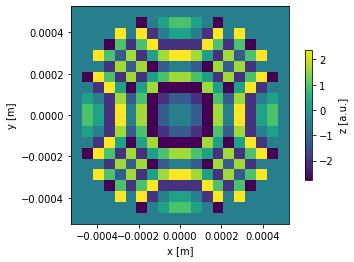

Mask has 400 number of points distributed in 8 layers
Creating individual pixel polygons
Progress: [####################] 100.0%
[Create Polygons]
Elapsed: 0:00:00.007992
[Total time converting to GDS]
Elapsed: 0:00:00.008991


In [6]:
# Create empty mask

N = 20
mask = moe.generate.create_empty_aperture(-500*micro, 500*micro, N, -500*micro, 500*micro, N,)
# f=50mm, lambda=532nm, R=500µm
mask = moe.generate.fresnel_phase(mask, 50*milli, 532*nano, radius=500*micro)

# Discretize mask with 8 layers
mask.discretize(8)
moe.plotting.plot_aperture(mask, )

# Create GDSMask
gdsmask = moe.GDSMask(mask)

# Create layout and merge polygons together
gdsmask.create_layout(merge=False)

# gdsmask.total_polygons

In [7]:
# View layout with embedded gdspy viewer
gdsmask.view_layout()

In [23]:
# Save layout to gdsfile

gdsmask.write_gds("test8.gds")

Saved test8.gds


In [25]:
gdsmask.gdslib.write_svg("test8.svg")

AttributeError: 'GdsLibrary' object has no attribute 'write_svg'

In [28]:
gdsmask.gdslib.cells['mask'].write_svg("test8.svg")

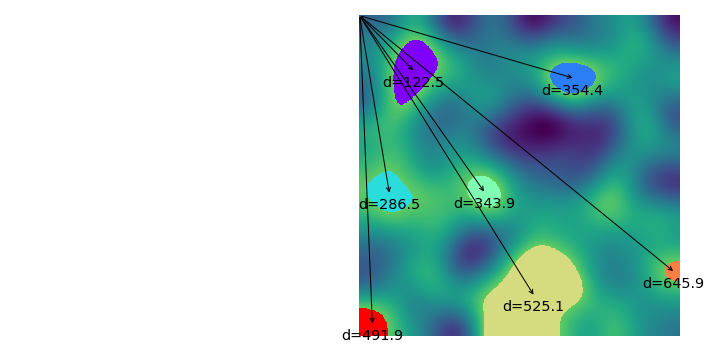

In [7]:
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt

# generate some lowpass-filtered noise as a test image
gen = np.random.RandomState(0)
img = gen.poisson(2, size=(512, 512))
img = ndimage.gaussian_filter(img.astype(np.double), (30, 30))
img -= img.min()
img /= img.max()

# use a boolean condition to find where pixel values are > 0.75
blobs = img > 0.75

# label connected regions that satisfy this condition
labels, nlabels = ndimage.label(blobs)

# find their centres of mass. in this case I'm weighting by the pixel values in
# `img`, but you could also pass the boolean values in `blobs` to compute the
# unweighted centroids.
r, c = np.vstack(ndimage.center_of_mass(img, labels, np.arange(nlabels) + 1)).T

# find their distances from the top-left corner
d = np.sqrt(r*r + c*c)

# plot
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
ax[1].imshow(img)

ax[1].imshow(np.ma.masked_array(labels, ~blobs), cmap=plt.cm.rainbow)
for ri, ci, di in zip(r, c, d):
    ax[1].annotate('', xy=(0, 0), xytext=(ci, ri),
                   arrowprops={'arrowstyle':'<-', 'shrinkA':0})
    ax[1].annotate('d=%.1f' % di, xy=(ci, ri),  xytext=(0, -5),
                   textcoords='offset points', ha='center', va='top',
                   fontsize='x-large')
for aa in ax.flat:
    aa.set_axis_off()
fig.tight_layout()
plt.show()

In [8]:
blobs

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

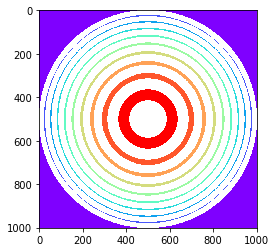

In [9]:
blobs = mask.amplitude>0
labels, nlabels = ndimage.label(blobs)
plt.imshow(np.ma.masked_array(labels, ~blobs), cmap=plt.cm.rainbow)
# plt.imshow(blobs, cmap=plt.cm.rainbow)


In [10]:
from skimage import measure

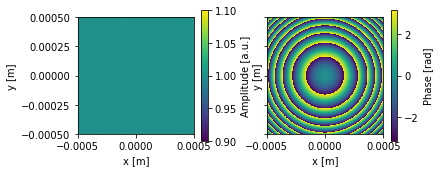

In [11]:
# Create empty mask
mask = moe.generate.create_empty_aperture(-500*micro, 500*micro, 1001, -500*micro, 500*micro, 1001,)
# f=50mm, lambda=532nm, R=500µm
mask = moe.generate.fresnel_phase(mask, 50*milli, 532*nano, )
moe.plotting.plot_aperture(mask, )

In [12]:
phase = mask.phase

np.max(phase),np.min(phase),np.ptp(phase)

levels = np.linspace(-np.pi, np.pi, 5)
levels

array([-3.14159265, -1.57079633,  0.        ,  1.57079633,  3.14159265])

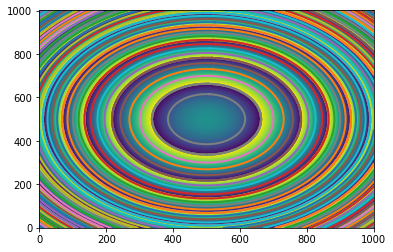

In [13]:
plt.pcolormesh(phase)

for level in levels:
    contours = measure.find_contours(phase, level)


    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

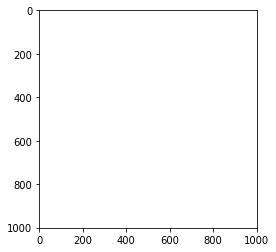

In [14]:
blobs = phase>3
labels, nlabels = ndimage.label(blobs)
plt.imshow(np.ma.masked_array(labels, ~blobs), cmap=plt.cm.rainbow)
# plt.imshow(blobs, cmap=plt.cm.rainbow)


(slice(0, 1001, None), slice(0, 1001, None))


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

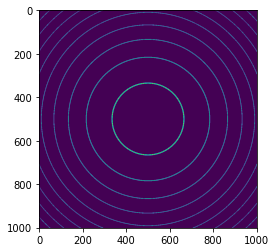

In [15]:
objs = ndimage.find_objects(blobs)

for obj in objs:
    print(obj)
    plt.imshow(blobs[obj])
    break
blobs[obj]

In [16]:

def grayim2gds_writer(infile, outfile, pixelx, pixely, cellname, level, layer=0, datatype=0 , verbose=False):
    """
    (void) Transforms one image (converted to grayscale) into a gds, using cv2 for reading the image
    by default adds the image to (layer, datatype) = (0,0)
    'infile'  = input IMAGE file (on extension that cv2 can read ), e.g. "image.png"
    'outfile' = output GDS file, e.g. "image.gds"
    'pixelx'  = pixel size in x, in um 
    'pixely'  = pixel size in y, in um 
    'cellname'= string with cellname, e.g. "TOP"
    'level'   = int from 0 to 255 (0 = black, 255=white) , pixels gray value to be passed to GDS 

    optional:
    'layer' = gray level, defaults to 0 
    'datatype' = gds datatype, defaults to 0 
    'verbose' defaults to False, if True prints 
    
    ---- 
    Usage example: 
    
    infilxe = "image.png"
    outfilxe = "image.gds"
    cellname = "TOP" #name of the gds cell 
    graycolor = 0 #black pixels 
    pixelx = 1 #um 
    pixely = 1 #um 

    grayim2gds_writer(infilxe, outfilxe, pixelx, pixely,cellname, graycolor, verbose=True)"""
    import cv2
    import gdspy 
    import numpy as np 

    img = cv2.imread(infile, cv2.IMREAD_GRAYSCALE)
    
    if img is not None: 
        print("Sucessfully imported img!")
        
    h,w = img.shape 
    print(h)
    print(w) 
    
    nmx = w
    nmy = h
    
    harray = np.arange(0,h+1,nmy)
    warray = np.arange(0,w+1,nmx)
    #print(harray)
    
    lib = gdspy.GdsLibrary()
    gdspy.current_library = gdspy.GdsLibrary() 

    outfilen = outfile
    writer = gdspy.GdsWriter(outfilen,unit=1.0e-6,precision=1.0e-9)
    cell = lib.new_cell(cellname)
    
    for hn, hi in enumerate(harray):
        if hn == (len(harray)-1):
            #writer.close()
            break
        #print(hi)
        for hw, wi in enumerate(warray):
            if hw == (len(warray)-1): 
                break   
            #print(wi)

            for i in np.arange(hi,hi+nmy):
                if verbose == True: 
                    print(i/h)
                
                for j in np.arange(wi, wi+nmx):
                    #print(j/w)
                    #here we can also think of selectin pixels at a certain level only
                    #and creating a GDS from a grayscale image 
                    if img[i][j] == int(level):
                        #rectangle takes the two  opposite corners 
                        #pols.append(gdspy.Rectangle((pixelx*j,-pixely*i),(pixelx*(j+1), -pixely*(i+1)), layer, datatype))
                        rect = gdspy.Rectangle((pixelx*j,-pixely*i),(pixelx*(j+1), -pixely*(i+1)), layer, datatype)
                        
                        cell.add(rect)
                
                writer.write_cell(cell)

        writer.close()

    print("Exported the image file "+str(infile) + " into " + str(outfile))


In [17]:

from IPython.display import clear_output
def progress_bar(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)


array([ 0.        ,  1.02040816,  2.04081633,  3.06122449,  4.08163265,
        5.10204082,  6.12244898,  7.14285714,  8.16326531,  9.18367347,
       10.20408163, 11.2244898 , 12.24489796, 13.26530612, 14.28571429,
       15.30612245, 16.32653061, 17.34693878, 18.36734694, 19.3877551 ,
       20.40816327, 21.42857143, 22.44897959, 23.46938776, 24.48979592,
       25.51020408, 26.53061224, 27.55102041, 28.57142857, 29.59183673,
       30.6122449 , 31.63265306, 32.65306122, 33.67346939, 34.69387755,
       35.71428571, 36.73469388, 37.75510204, 38.7755102 , 39.79591837,
       40.81632653, 41.83673469, 42.85714286, 43.87755102, 44.89795918,
       45.91836735, 46.93877551, 47.95918367, 48.97959184, 50.        ])

In [86]:
# Create empty mask
mask = moe.generate.create_empty_aperture(-500*micro, 500*micro, 101, -500*micro, 500*micro, 101,)
# f=50mm, lambda=532nm, R=500µm
mask = moe.generate.fresnel_phase(mask, 50*milli, 532*nano, )
moe.plotting.plot_aperture(mask, )


mask.phase

phase = mask.phase

blob = phase>0

plt.figure()
plt.imshow(blob)

AssertionError: aperture given is not an Aperture object

In [11]:


# def newGDSMask(aperture, which):
#     """
#     Creates a new GDSMask object loading from aperture
#     """
#     assert type(aperture) is moe.Aperture, "provided aperture must be of type Aperture"
#     assert which in ["phase", "amplitude"], "which must be amplitude or phase"
    
#     if which == "phase":
#         array = aperture.phase
#     elif which == "amplitude":
#         array = aperture.amplitude
#     else:    
#         return -1
#     gdsmask = GDSMask(XX=aperture.XX,
#                    YY=aperture.YY,
#                    mask=array,
#                    pixel_x = aperture.pixel_x,
#                    pixel_y = aperture.pixel_y,
#                   )
#     return gdsmask

In [54]:
units = micro
precision = nano

cellname = "cell1"
layer = 0
datatype = 0

outfile = "test.gds"

lib = gdspy.GdsLibrary()
gdspy.current_library = gdspy.GdsLibrary() 

outfilen = outfile
writer = gdspy.GdsWriter(outfile,unit=micro,precision=precision)
cell = lib.new_cell(cellname)

size_x, size_y = blob.shape
XX = mask.XX
YY = mask.YY

half_pixel_x = mask.pixel_x/2
half_pixel_y = mask.pixel_y/2

warray = range(size_x)
harray = range(size_y)



# normalize to units:
XX = XX/units
YY = YY/units
half_pixel_x = half_pixel_x/units
half_pixel_y = half_pixel_y/units

total_points = size_x*size_y

for i in range(size_x):
    for j in range(size_y):
        current_point = i*size_x+j
        
        #         print(i,j, XX[i,j], YY[i,j], blob[i,j])
        if blob[i,j]:
            x = XX[i,j]
            y = YY[i,j]
            rectangle_first_corner = (x-half_pixel_x,y-half_pixel_y)
            rectangle_second_corner = (x+half_pixel_x,y+half_pixel_y)
            rect = gdspy.Rectangle(rectangle_first_corner, rectangle_second_corner, layer, datatype)
            
            
            cell.add(rect)
#             merged = gdspy.boolean(cell, rect, "or")
#             # remove existing polygons from cell
#             cell.remove_polygons(lambda pts, layer, datatype: True)
#             cell.add(merged)
    progress_bar(current_point/total_points)
writer.write_cell(cell)

writer.close()
        

NameError: name 'blob' is not defined

In [55]:
lib.write_gds("test3.gds")

In [45]:
type(merged.polygons[0])

numpy.ndarray

In [48]:

def merge_polygons(polygons, verbose=True):

    total_polygons = len(polygons)

    for i,pol in enumerate(polygons):
        if i%100==0 & verbose:
            progress_bar(i/total_polygons)

        # first polygon
        if i == 0:
            merged = pol
            continue
        merged = gdspy.boolean(merged, pol, "or")
    progress_bar(i+1/total_polygons)
    return merged


merged = merge_polygons(cell.polygons)

Progress: [####################] 100.0%


In [53]:
cellnames = list(gdsmask.gdslib.cells.keys())
cell = gdsmask.gdslib.cells[cellnames[0]]
cell.paths



[]

In [21]:
merged.get_bounding_box()
merged


lib = gdspy.GdsLibrary()
gdspy.current_library = gdspy.GdsLibrary() 


cell = lib.new_cell(cellname)

cell.add(merged)
gdspy.LayoutViewer()

C:\Users\diogo\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: [GDSPY] Use of the global library is deprecated.  Pass LayoutViewer a GdsLibrary instance.
  if sys.path[0] == '':


<gdspy.viewer.LayoutViewer object .!layoutviewer>

In [30]:
len(merged.polygons[0]), merged.layers, print(merged)

PolygonSet (29 polygons, 2571 vertices, layers [0], datatypes [0])


(18,
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 None)

In [133]:
lib = gdspy.GdsLibrary()
gdspy.current_library = gdspy.GdsLibrary() 


cell = lib.new_cell(cellname)

rect1 = gdspy.Rectangle((0,0), (10,10), layer, datatype)
cell.add(rect1)
rect2 = gdspy.Rectangle((10,0), (20,10), layer, datatype)
merged = gdspy.boolean(cell, rect2, "or")
# cell.remove_polygons(lambda pts, layer, datatype: layer == 1)
cell.remove_polygons(lambda pts, layer, datatype: True)
cell.add(merged)

gdspy.LayoutViewer()

C:\Users\diogo\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: [GDSPY] Use of the global library is deprecated.  Pass LayoutViewer a GdsLibrary instance.
  from ipykernel import kernelapp as app


KeyboardInterrupt: 

In [122]:
# boolean operation

merged_cell = lib.new_cell("merged")
merged = gdspy.boolean(merged_cell, cell, "or")
merged_cell.add(merged)

In [123]:
merged

In [86]:
for hn, hi in enumerate(harray):
    if hn == (len(harray)-1):
        #writer.close()
        break
    #print(hi)
    for hw, wi in enumerate(warray):
        if hw == (len(warray)-1): 
            break   
        #print(wi)

        for i in np.arange(hi,hi+nmy):
            if verbose == True: 
                print(i/h)

            for j in np.arange(wi, wi+nmx):
                #print(j/w)
                #here we can also think of selectin pixels at a certain level only
                #and creating a GDS from a grayscale image 
                if img[i][j] == int(level):
                    #rectangle takes the two  opposite corners 
                    #pols.append(gdspy.Rectangle((pixelx*j,-pixely*i),(pixelx*(j+1), -pixely*(i+1)), layer, datatype))
                    rect = gdspy.Rectangle((pixelx*j,-pixely*i),(pixelx*(j+1), -pixely*(i+1)), layer, datatype)

                    cell.add(rect)

            writer.write_cell(cell)

    writer.close()

NameError: name 'nmy' is not defined